# DATA 643 - Final Project 

### Sreejaya Nair and Suman K Polavarapu

#### Description: 
*Explore the Apache Spark Cluster Computing Framework by analysing the movielens dataset. Provide recommendations using MLLib*

In [1]:
import os
import sys
import urllib2
import collections
import matplotlib.pyplot as plt
import math
from time import time, sleep
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Prepare the pySpark Environment

In [2]:
spark_home = os.environ.get('SPARK_HOME', None)

if not spark_home:    
    raise ValueError("Please set SPARK_HOME environment variable!")

# Add the py4j to the path.
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'C:/spark/python/lib/py4j-0.9-src.zip'))


## Initialize Spark Context

In [3]:
from pyspark.mllib.recommendation import ALS, Rating
from pyspark import SparkConf, SparkContext

In [4]:
conf = SparkConf().setMaster("local[*]").setAppName("MovieRecommendationsALS").set("spark.executor.memory", "2g")
sc = SparkContext(conf = conf)

## Load and Analyse Data

In [5]:
def loadMovieNames():
    movieNames = {}
    for line in urllib2.urlopen("https://raw.githubusercontent.com/psumank/DATA643/master/WK5/ml-100k/u.item"):
        fields = line.split('|')
        movieNames[int(fields[0])] = fields[1].decode('ascii', 'ignore')
    return movieNames

In [6]:
print "\nLoading movie names..."
nameDict = loadMovieNames()

print "\nLoading ratings data..."
data = sc.textFile("file:///C:/Users/p_sum/.ipynb_checkpoints/ml-100k/u.data")


Loading movie names...

Loading ratings data...


In [7]:
ratings = data.map(lambda x: x.split()[2])

#action -- just to trigger the driver [ lazy evaluation ]
rating_results = ratings.countByValue()

sortedResults = collections.OrderedDict(sorted(rating_results.items()))
for key, value in sortedResults.iteritems():
    print "%s %i" % (key, value)

1 6110
2 11370
3 27145
4 34174
5 21201


### Ratings Histogram

Ratings Histogram


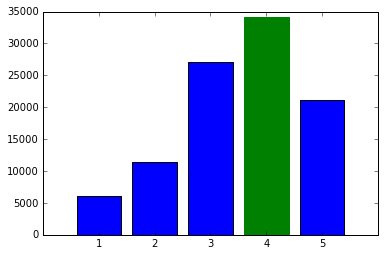

In [8]:
ratPlot = plt.bar(range(len(sortedResults)), sortedResults.values(), align='center')
plt.xticks(range(len(sortedResults)), list(sortedResults.keys()))
ratPlot[3].set_color('g')
print "Ratings Histogram"


### Most popular movies

In [9]:
movies = data.map(lambda x: (int(x.split()[1]), 1))
movieCounts = movies.reduceByKey(lambda x, y: x + y)
flipped = movieCounts.map( lambda (x, y) : (y, x))
sortedMovies = flipped.sortByKey(False)
sortedMoviesWithNames = sortedMovies.map(lambda (count, movie) : (nameDict[movie], count))

In [10]:
results = sortedMoviesWithNames.collect()
subset = results[0:10]
popular_movieNm = [str(i[0]) for i in subset]
popularity_strength = [int(i[1]) for i in subset]

Most Popular Movies from the Dataset


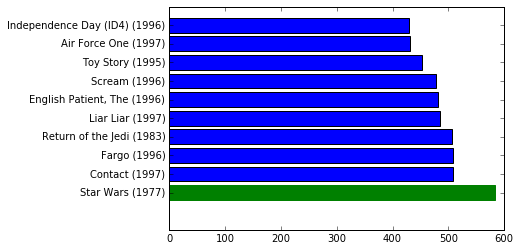

In [11]:
popMovplot = plt.barh(range(len(subset)), popularity_strength, align='center')
plt.yticks(range(len(subset)), popular_movieNm)
popMovplot[0].set_color('g')
print "Most Popular Movies from the Dataset"


### Similar Movies

Find similar movies for a given movie using cosine similarity

In [12]:
ratingsRDD = data.map(lambda l: l.split()).map(lambda l: (int(l[0]), (int(l[1]), float(l[2]))))


In [13]:
ratingsRDD.takeOrdered(10, key = lambda x: x[0])

[(1, (61, 4.0)),
 (1, (189, 3.0)),
 (1, (33, 4.0)),
 (1, (160, 4.0)),
 (1, (20, 4.0)),
 (1, (202, 5.0)),
 (1, (171, 5.0)),
 (1, (265, 4.0)),
 (1, (155, 2.0)),
 (1, (117, 3.0))]

In [14]:
ratingsRDD.take(4)

[(196, (242, 3.0)), (186, (302, 3.0)), (22, (377, 1.0)), (244, (51, 2.0))]

In [15]:
# Movies rated by same user. ==> [ user ID ==> ( (movieID, rating), (movieID, rating)) ]
userJoinedRatings = ratingsRDD.join(ratingsRDD)

userJoinedRatings.takeOrdered(10, key = lambda x: x[0])

[(1, ((61, 4.0), (61, 4.0))),
 (1, ((61, 4.0), (189, 3.0))),
 (1, ((61, 4.0), (33, 4.0))),
 (1, ((61, 4.0), (160, 4.0))),
 (1, ((61, 4.0), (20, 4.0))),
 (1, ((61, 4.0), (202, 5.0))),
 (1, ((61, 4.0), (171, 5.0))),
 (1, ((61, 4.0), (265, 4.0))),
 (1, ((61, 4.0), (155, 2.0))),
 (1, ((61, 4.0), (117, 3.0)))]

In [16]:
# Remove dups
def filterDups( (userID, ratings) ):
    (movie1, rating1) = ratings[0]
    (movie2, rating2) = ratings[1]
    return movie1 < movie2

uniqueUserJoinedRatings = userJoinedRatings.filter(filterDups)

uniqueUserJoinedRatings.takeOrdered(10, key = lambda x: x[0])

[(1, ((61, 4.0), (189, 3.0))),
 (1, ((61, 4.0), (160, 4.0))),
 (1, ((61, 4.0), (202, 5.0))),
 (1, ((61, 4.0), (171, 5.0))),
 (1, ((61, 4.0), (265, 4.0))),
 (1, ((61, 4.0), (155, 2.0))),
 (1, ((61, 4.0), (117, 3.0))),
 (1, ((61, 4.0), (222, 4.0))),
 (1, ((61, 4.0), (253, 5.0))),
 (1, ((61, 4.0), (113, 5.0)))]

In [17]:
# Now key by (movie1, movie2) pairs ==> (movie1, movie2) => (rating1, rating2)
def makeMovieRatingPairs((user, ratings)):
    (movie1, rating1) = ratings[0]
    (movie2, rating2) = ratings[1]
    return ((movie1, movie2), (rating1, rating2))

moviePairs = uniqueUserJoinedRatings.map(makeMovieRatingPairs)

moviePairs.takeOrdered(10, key = lambda x: x[0])

[((1, 2), (4.0, 3.0)),
 ((1, 2), (4.0, 3.0)),
 ((1, 2), (4.0, 3.0)),
 ((1, 2), (5.0, 4.0)),
 ((1, 2), (4.0, 3.0)),
 ((1, 2), (5.0, 3.0)),
 ((1, 2), (5.0, 5.0)),
 ((1, 2), (5.0, 4.0)),
 ((1, 2), (5.0, 4.0)),
 ((1, 2), (3.0, 4.0))]

In [18]:
#collect all ratings for each movie pair and compute similarity. (movie1, movie2) = > (rating1, rating2), (rating1, rating2) ...
moviePairRatings = moviePairs.groupByKey()
moviePairRatings.takeOrdered(10, key = lambda x: x[0])

[((1, 2), <pyspark.resultiterable.ResultIterable at 0xaa92da0>),
 ((1, 3), <pyspark.resultiterable.ResultIterable at 0xaa92908>),
 ((1, 4), <pyspark.resultiterable.ResultIterable at 0xa5ca588>),
 ((1, 5), <pyspark.resultiterable.ResultIterable at 0xac252e8>),
 ((1, 6), <pyspark.resultiterable.ResultIterable at 0xaa92fd0>),
 ((1, 7), <pyspark.resultiterable.ResultIterable at 0xaabb208>),
 ((1, 8), <pyspark.resultiterable.ResultIterable at 0xa5ca748>),
 ((1, 9), <pyspark.resultiterable.ResultIterable at 0xac25128>),
 ((1, 10), <pyspark.resultiterable.ResultIterable at 0xaa92940>),
 ((1, 11), <pyspark.resultiterable.ResultIterable at 0xaabba90>)]

In [19]:
#Compute Similarity
def cosineSimilarity(ratingPairs):
    numPairs = 0
    sum_xx = sum_yy = sum_xy = 0
    for ratingX, ratingY in ratingPairs:
        sum_xx += ratingX * ratingX
        sum_yy += ratingY * ratingY
        sum_xy += ratingX * ratingY
        numPairs += 1

    numerator = sum_xy
    denominator = sqrt(sum_xx) * sqrt(sum_yy)

    score = 0
    if (denominator):
        score = (numerator / (float(denominator)))

    return (score, numPairs)

moviePairSimilarities = moviePairRatings.mapValues(cosineSimilarity).cache()

moviePairSimilarities.takeOrdered(10, key = lambda x: x[0])

[((1, 2), (0.9487373941786248, 104)),
 ((1, 3), (0.9132997212006829, 78)),
 ((1, 4), (0.9429068878509639, 149)),
 ((1, 5), (0.9613638498709224, 57)),
 ((1, 6), (0.9551193973874768, 14)),
 ((1, 7), (0.948915528102488, 281)),
 ((1, 8), (0.9600459451420741, 154)),
 ((1, 9), (0.9387445181517423, 201)),
 ((1, 10), (0.943039377274702, 61)),
 ((1, 11), (0.9573860685968381, 160))]

#### Lets find similar movies for Toy Story (Movie ID: 1)

In [20]:
scoreThreshold = 0.97
coOccurenceThreshold = 50

inputMovieID = 1  #Toy Story. 

# Filter for movies with this sim that are "good" as defined by our quality thresholds.
filteredResults = moviePairSimilarities.filter(lambda((pair,sim)): \
    (pair[0] == inputMovieID or pair[1] == inputMovieID) and sim[0] > scoreThreshold and sim[1] > coOccurenceThreshold)

In [21]:
 #Top 10 by quality score.
    
results = filteredResults.map(lambda((pair,sim)): (sim, pair)).sortByKey(ascending = False).take(10)

print "Top 10 similar movies for " + nameDict[inputMovieID]

for result in results:
    (sim, pair) = result
    # Display the similarity result that isn't the movie we're looking at
    similarMovieID = pair[0]
    if (similarMovieID == inputMovieID):
        similarMovieID = pair[1]
    print nameDict[similarMovieID] + "\tscore: " + str(sim[0]) + "\tstrength: " + str(sim[1])

Top 10 similar movies for Toy Story (1995)
Hamlet (1996)	score: 0.974543871512	strength: 67
Raiders of the Lost Ark (1981)	score: 0.974084217219	strength: 273
Cinderella (1950)	score: 0.974002987747	strength: 105
Winnie the Pooh and the Blustery Day (1968)	score: 0.973415495885	strength: 58
Cool Hand Luke (1967)	score: 0.97334234772	strength: 98
Great Escape, The (1963)	score: 0.973270581613	strength: 77
African Queen, The (1951)	score: 0.973151271508	strength: 101
Apollo 13 (1995)	score: 0.972395120538	strength: 207
12 Angry Men (1957)	score: 0.971987295102	strength: 81
Wrong Trousers, The (1993)	score: 0.971814306667	strength: 90


### Recommender using MLLib

#### Training the recommendation model

In [22]:
ratings = data.map(lambda l: l.split()).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2]))).cache()
ratings.take(3)

[Rating(user=196, product=242, rating=3.0),
 Rating(user=186, product=302, rating=3.0),
 Rating(user=22, product=377, rating=1.0)]

In [23]:
nratings  = ratings.count()
nUsers    = ratings.keys().distinct().count()
nMovies   = ratings.values().distinct().count()

print "We have Got %d ratings from %d users on %d movies." % (nratings, nUsers, nMovies)

We have Got 100000 ratings from 943 users on 1682 movies.


In [24]:
# Build the recommendation model using Alternating Least Squares
#Train a matrix factorization model given an RDD of ratings given by users to items, in the form of
#(userID, itemID, rating) pairs. We approximate the ratings matrix as the product of two lower-rank matrices 
#of a given rank (number of features). To solve for these features, we run a given number of iterations of ALS. 
#The level of parallelism is determined automatically based on the number of partitions in ratings.

start = time()

seed = 5L
iterations = 10
rank = 8

model = ALS.train(ratings, rank, iterations)

duration = time() - start

print "Model trained in %s seconds" % round(duration,3)

Model trained in 5.348 seconds


#### Recommendations

In [25]:
#Lets recommend movies for the user id - 2
userID = 2

In [26]:
print "\nTop 10 recommendations:"
recommendations = model.recommendProducts(userID, 10)
for recommendation in recommendations:
    print nameDict[int(recommendation[1])] + \
        " score " + str(recommendation[2])


Top 10 recommendations:
Angel Baby (1995) score 6.74090812395
Boys, Les (1997) score 5.74061718139
Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970) score 5.65833859894
So Dear to My Heart (1949) score 5.60576449192
Little Princess, The (1939) score 5.39192446513
Pather Panchali (1955) score 5.23277505161
Schindler's List (1993) score 5.217745347
Boys of St. Vincent, The (1993) score 5.16451370716
Everest (1998) score 5.15822530534
Faust (1994) score 5.13845975641
